# **Week 4 Assignment: Saliency Maps**

Welcome to the final programming exercise of this course! For this week, your task is to adapt the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) Class Activation Map ungraded lab (the second ungraded lab of this week) and make it generate saliency maps instead.

As discussed in the lectures, a saliency map shows the pixels which greatly impacts the classification of an image. 
- This is done by getting the gradient of the loss with respect to changes in the pixel values, then plotting the results. 
- From there, you can see if your model is looking at the correct features when classifying an image. 
  - For example, if you're building a dog breed classifier, you should be wary if your saliency map shows strong pixels outside the dog itself (e.g. sky, grass, dog house, etc...).

In this assignment you will be given prompts but less starter code to fill in in. 
- It's good practice for you to try and write as much of this code as you can from memory and from searching the web.
- **Whenever you feel stuck**, please refer back to the labs of this week to see how to write the code. In particular, look at:
  - **Ungraded Lab 2: Cats vs Dogs CAM**
  - **Ungraded Lab 3: Saliency**




### Download test files and weights

Let's begin by first downloading files we will be using for this lab.

In [1]:
# Download the same test files from the Cats vs Dogs ungraded lab
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

# Download prepared weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kipXTxesGJKGY1B8uSPRvxROgOH90fih' -O 0_epochs.h5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oiV6tjy5k7h9OHGTQaf0Ohn3FmF-uOs1' -O 15_epochs.h5


--2023-03-28 16:50:14--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.004s  

2023-03-28 16:50:14 (92.0 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2023-03-28 16:50:14--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Savi

### Import the required packages

Please import:

  * Tensorflow
  * Tensorflow Datasets
  * Numpy
  * Matplotlib's PyPlot
  * Keras plot_model utility
  * Keras Models API classes you will be using
  * Keras layers you will be using
  * OpenCV (cv2)

In [2]:
# YOUR CODE HERE
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, GlobalAveragePooling2D 
import cv2

### Download and prepare the dataset.



#### Load Cats vs Dogs 

* Required: Use Tensorflow Datasets to fetch the `cats_vs_dogs` dataset. 
  * Use the first 80% of the *train* split of the said dataset to create your training set.
  * Set the `as_supervised` flag to create `(image, label)` pairs.
    
* Optional: You can create validation and test sets from the remaining 20% of the *train* split of `cats_vs_dogs` (i.e. you already used 80% for the train set). This is if you intend to train the model beyond what is required for submission.

In [3]:
# Load the data and create the train set (optional: val and test sets)

# YOUR CODE HERE
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete6UP5Z4/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


#### Create preprocessing function

Define a function that takes in an image and label. This will:
  * cast the image to float32
  * normalize the pixel values to [0, 1]
  * resize the image to 300 x 300


In [4]:
def augmentimages(image, label):
  # YOUR CODE HERE
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (300, 300))
  return image, label

#### Preprocess the training set

Use the `map()` and pass in the method that you just defined to preprocess the training set.


In [5]:
augmented_training_data = train_data.map(augmentimages)

#### Create batches of the training set. 

This is already provided for you. Normally, you will want to shuffle the training set. But for predictability in the grading, we will simply create the batches.

```Python
# Shuffle the data if you're working on your own personal project 
train_batches = augmented_training_data.shuffle(1024).batch(32)
```

In [6]:
train_batches = augmented_training_data.batch(32)

### Build the Cats vs Dogs classifier 

You'll define a model that is nearly the same as the one in the Cats vs. Dogs CAM lab.
* Please preserve the architecture of the model in the Cats vs Dogs CAM lab (this week's second lab) except for the final `Dense` layer.
* You should modify the Cats vs Dogs model at the last dense layer to output 2 neurons instead of 1. 
  - This is because you will adapt the `do_salience()` function from the lab and that works with one-hot encoded labels. 
  - You can do this by changing the `units` argument of the output Dense layer from 1 to 2, with one for each of the classes (i.e. cats and dogs).
  - You should choose an activation that outputs a probability for each of the 2 classes (i.e. categories), where the sum of the probabilities adds up to 1.

In [7]:
# YOUR CODE HERE
model = tf.keras.models.Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0

**Expected Output:**

```txt
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
=================================================================
Total params: 97,698
Trainable params: 97,698
Non-trainable params: 0
_________________________________________________________________
```

### Create a function to generate the saliency map

Complete the `do_salience()` function below to save the **normalized_tensor** image. 
- The major steps are listed as comments below.
  - Each section may involve multiple lines of code.
- Try your best to write the code from memory or by performing web searches.
  - Whenever you get stuck, you can review the "saliency" lab (the third lab of this week) to help remind you of what code to write

In [8]:
def do_salience(image, model, label, prefix):
  '''
  Generates the saliency map of a given image.

  Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # Read the image and convert channel order from BGR to RGB
  # YOUR CODE HERE
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
  # YOUR CODE HERE
  img = cv2.resize(img, (300, 300))
  img = img/255.0
  # Add an additional dimension (for the batch), and save this in a new variable
  # YOUR CODE HERE
  expand_img = np.expand_dims(img, axis= 0)

  # Declare the number of classes
  # YOUR CODE HERE
  num_classes = 2
  
  # Define the expected output array by one-hot encoding the label
  # The length of the array is equal to the number of classes
  # YOUR CODE HERE
  expected_output = tf.one_hot([label] * expand_img.shape[0], num_classes)

  # Witin the GradientTape block:
  # Cast the image as a tf.float32
  # Use the tape to watch the float32 image
  # Get the model's prediction by passing in the float32 image
  # Compute an appropriate loss
  # between the expected output and model predictions.
  # you may want to print the predictions to see if the probabilities adds up to 1
  # YOUR CODE HERE
  with tf.GradientTape() as tape : 
    inputs = tf.cast(expand_img, tf.float32)

    tape.watch(inputs) 

    predictions = model(inputs) 

    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    ) 
    print(predictions)

  # get the gradients of the loss with respect to the model's input image
  # YOUR CODE HERE
  gradients = tape.gradient(loss, inputs)
    
  # generate the grayscale tensor
  # YOUR CODE HERE
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1) 

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  # Use the formula: 255 * (x - min) / (max - min)
  # Use tf.reduce_max, tf.reduce_min
  # Cast the tensor as a tf.uint8
  # YOUR CODE HERE
  normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
       ) 
    
  # Remove dimensions that are size 1
  # YOUR CODE HERE
  normalized_tensor = tf.squeeze(normalized_tensor)
    
  # plot the normalized tensor
  # Set the figure size to 8 by 8
  # do not display the axis
  # use the 'gray' colormap
  # This code is provided for you.
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalized_tensor, cmap='gray')
  plt.show()

  # optional: superimpose the saliency map with the original image, then display it.
  # we encourage you to do this to visualize your results better
  # YOUR CODE HERE


  # save the normalized tensor image to a file. this is already provided for you.
  salient_image_name = prefix + image
  normalized_tensor = tf.expand_dims(normalized_tensor, -1)
  normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  writer = tf.io.write_file(salient_image_name, normalized_tensor)

### Generate saliency maps with untrained model

As a sanity check, you will load initialized (i.e. untrained) weights and use the function you just implemented. 
- This will check if you built the model correctly and are able to create a saliency map. 

If an error pops up when loading the weights or the function does not run, please check your implementation for bugs.
- You can check the ungraded labs of this week.

Please apply your `do_salience()` function on the following image files:

* `cat1.jpg`
* `cat2.jpg`
* `catanddog.jpg`
* `dog1.jpg`
* `dog2.jpg`

Cats will have the label `0` while dogs will have the label `1`. 
- For the catanddog, please use `0`. 
- For the prefix of the salience images that will be generated, please use the prefix `epoch0_salient`.

tf.Tensor([[0.49321154 0.5067885 ]], shape=(1, 2), dtype=float32)


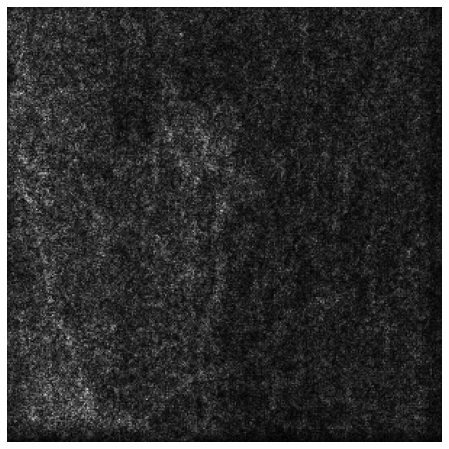

tf.Tensor([[0.49322364 0.5067764 ]], shape=(1, 2), dtype=float32)


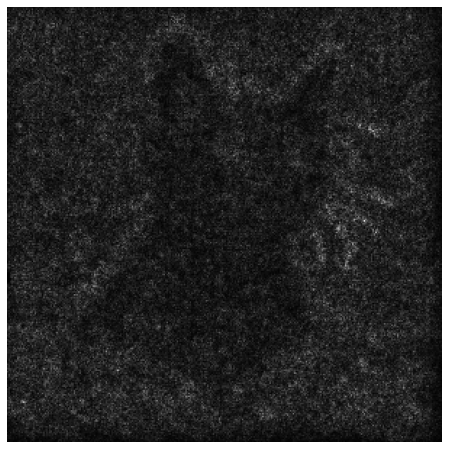

tf.Tensor([[0.4922674 0.5077326]], shape=(1, 2), dtype=float32)


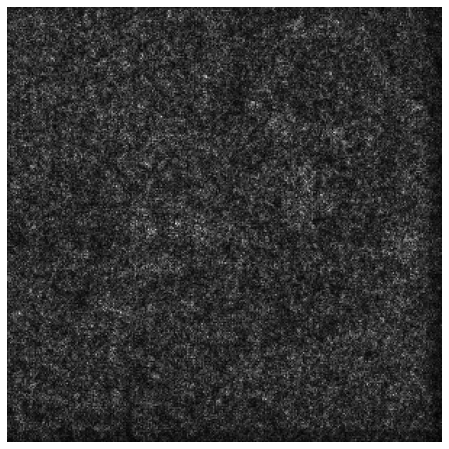

tf.Tensor([[0.49055642 0.5094436 ]], shape=(1, 2), dtype=float32)


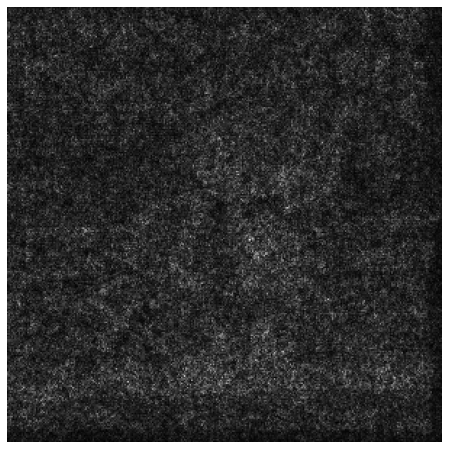

tf.Tensor([[0.49038067 0.50961936]], shape=(1, 2), dtype=float32)


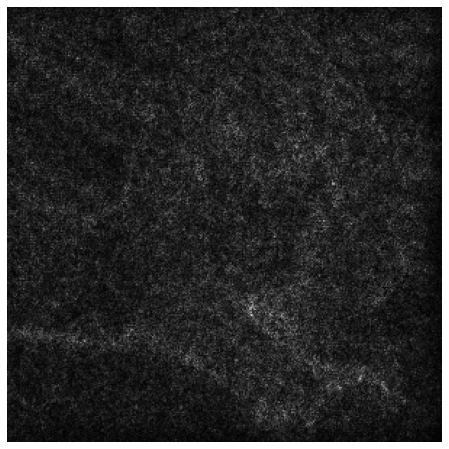

In [9]:
# load initial weights
model.load_weights('0_epochs.h5')

# generate the saliency maps for the 5 test images
# YOUR CODE HERE
do_salience('cat1.jpg', model, 0, 'epoch0_salient') 
do_salience('cat2.jpg', model, 0, 'epoch0_salient') 
do_salience('catanddog.jpg', model, 0, 'epoch0_salient')  
do_salience('dog1.jpg', model, 1, 'epoch0_salient')  
do_salience('dog2.jpg', model, 1, 'epoch0_salient')

With untrained weights, you will see something like this in the output. 
- You will see strong pixels outside the cat that the model uses that when classifying the image. 
- After training that these will slowly start to localize to features inside the pet.

<img src='https://drive.google.com/uc?export=view&id=1h5wP52lwbBUMVLlsgyb-tQl_I9eu42X7' alt='saliency'>


### Configure the model for training

Use `model.compile()` to define the loss, metrics and optimizer. 

* Choose a loss function for the model to use when training. 
  - For `model.compile()` the ground truth labels from the training set are passed to the model as **integers** (i.e. 0 or 1) as opposed to one-hot encoded vectors.
  - The model predictions are class probabilities. 
  - You can browse the [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and determine which one is best used for this case. 
  - Remember that you can pass the function as a string (e.g. `loss = 'loss_function_a'`). 

* For metrics, you can measure `accuracy`. 
* For the optimizer, please use [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop).
  - Please use the default learning rate of `0.001`.

In [10]:
# YOUR CODE HERE
optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

### Train your model

Please pass in the training batches and train your model for just **3** epochs. 
- **Note:** Please do not exceed 3 epochs because the grader will expect 3 epochs when grading your output.
  - After submitting your zipped folder for grading, feel free to continue training to improve your model.

We have loaded pre-trained weights for 15 epochs so you can get a better output when you visualize the saliency maps.

In [11]:
# load pre-trained weights
model.load_weights('15_epochs.h5')

# train the model for just 3 epochs
# YOUR CODE HERE 

EPOCHS = 3
model.fit(train_batches  ,
          epochs=EPOCHS   
          )

Epoch 1/3
582/582 [==============================] - 46s 73ms/step - loss: 0.4432 - accuracy: 0.8019
Epoch 2/3
582/582 [==============================] - 44s 76ms/step - loss: 0.4315 - accuracy: 0.8090
Epoch 3/3
582/582 [==============================] - 42s 73ms/step - loss: 0.4224 - accuracy: 0.8143


### Generate saliency maps at 18 epochs

You will now use your `do_salience()` function again on the same test images. Please use the same parameters as before but this time, use the prefix `salient`.

tf.Tensor([[0.30705854 0.6929415 ]], shape=(1, 2), dtype=float32)


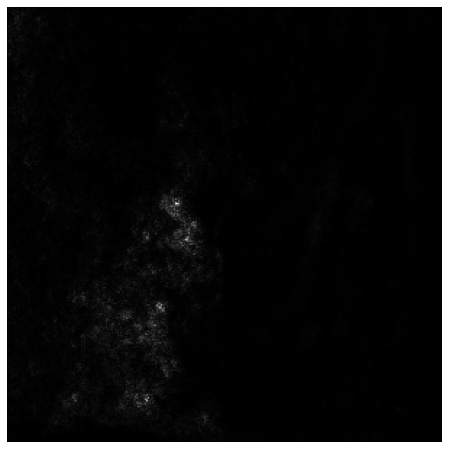

tf.Tensor([[0.75599384 0.2440062 ]], shape=(1, 2), dtype=float32)


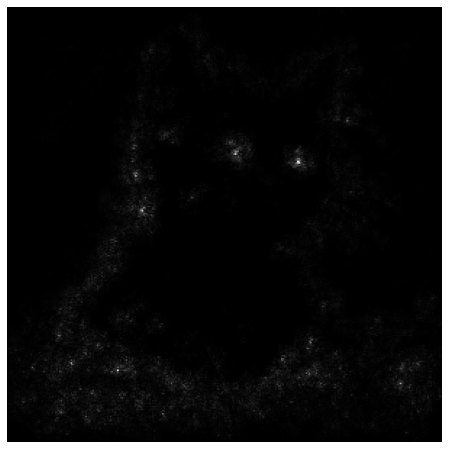

tf.Tensor([[0.24472818 0.75527185]], shape=(1, 2), dtype=float32)


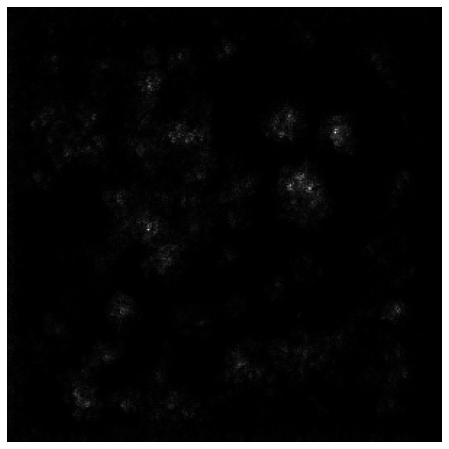

tf.Tensor([[0.22847417 0.7715258 ]], shape=(1, 2), dtype=float32)


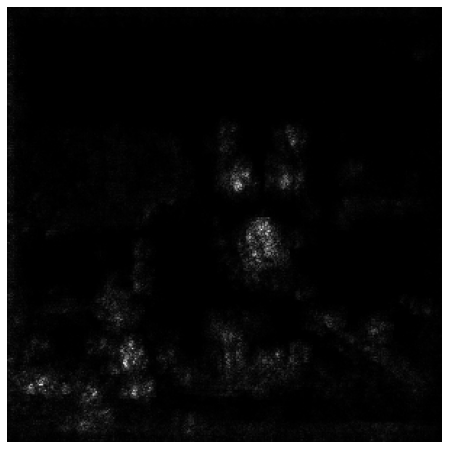

tf.Tensor([[0.3710376  0.62896246]], shape=(1, 2), dtype=float32)


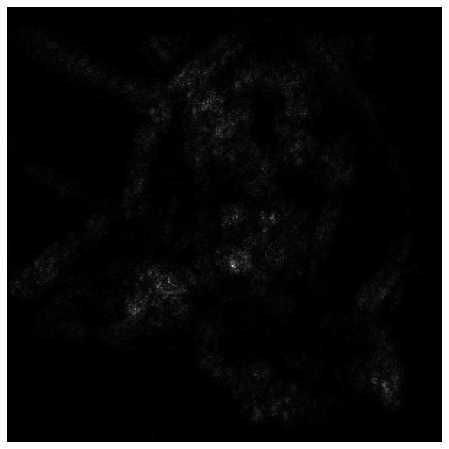

In [12]:
# YOUR CODE HERE
do_salience('cat1.jpg', model, 0, 'salient') 
do_salience('cat2.jpg', model, 0, 'salient') 
do_salience('catanddog.jpg', model, 0, 'salient')  
do_salience('dog1.jpg', model, 1, 'salient')  
do_salience('dog2.jpg', model, 1, 'salient')

You should see that the strong pixels are now very less than the ones you generated earlier. Moreover, most of them are now found on features within the pet.

### Zip the images for grading

Please run the cell below to zip the normalized tensor images you generated at 18 epochs. If you get an error, please check that you have files named:

* salientcat1.jpg
* salientcat2.jpg
* salientcatanddog.jpg
* salientdog1.jpg
* salientdog2.jpg

Afterwards, please download the **images.zip** from the Files bar on the left.

In [13]:
from zipfile import ZipFile

!rm images.zip

filenames = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']

# writing files to a zipfile 
with ZipFile('images.zip','w') as zip:
  for file in filenames:
    zip.write('salient' + file)

print("images.zip generated!")

rm: cannot remove 'images.zip': No such file or directory
images.zip generated!


### Optional: Saliency Maps at 95 epochs

We have pre-trained weights generated at 95 epochs and you can see the difference between the maps you generated at 18 epochs.

--2023-03-28 16:54:03--  https://docs.google.com/uc?export=download&id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY
Resolving docs.google.com (docs.google.com)... 64.233.182.138, 64.233.182.100, 64.233.182.102, ...
Connecting to docs.google.com (docs.google.com)|64.233.182.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/joio14lqp0jf23a8sb4cib50mnnd8b9h/1680022425000/17311369472417335306/*/14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY?e=download&uuid=1c93c7e2-7fe4-4dde-bf66-ff65a62ba81f [following]
--2023-03-28 16:54:04--  https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/joio14lqp0jf23a8sb4cib50mnnd8b9h/1680022425000/17311369472417335306/*/14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY?e=download&uuid=1c93c7e2-7fe4-4dde-bf66-ff65a62ba81f
Resolving doc-0o-6k-docs.googleusercontent.com (doc-0o-6k-docs.googleusercontent.com)... 173.194.198.132, 2607:f8b0

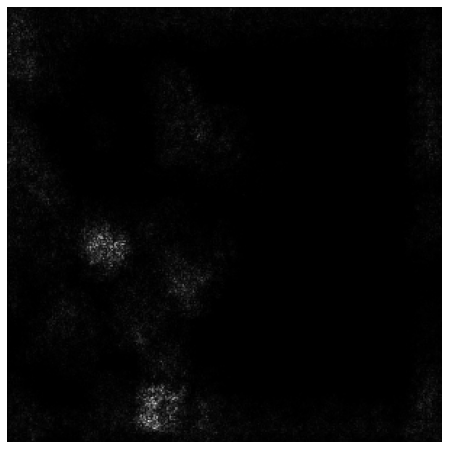

tf.Tensor([[0.9623281  0.03767189]], shape=(1, 2), dtype=float32)


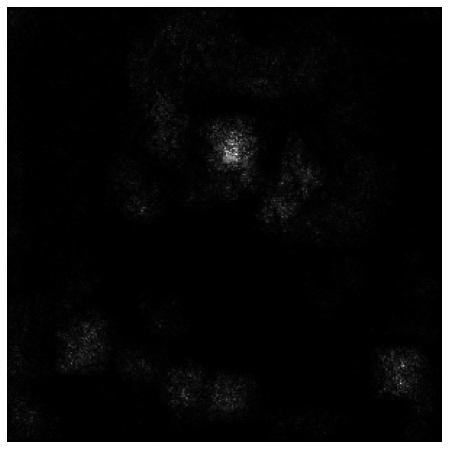

tf.Tensor([[0.9900357  0.00996429]], shape=(1, 2), dtype=float32)


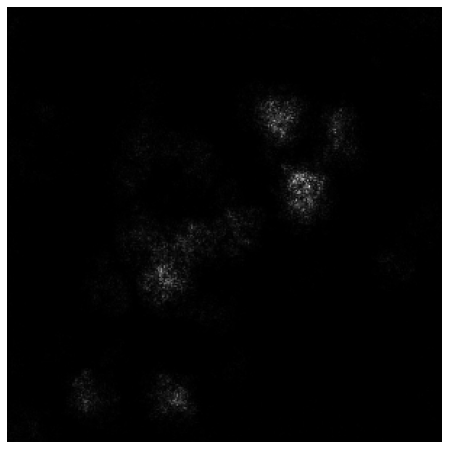

tf.Tensor([[1.1879398e-04 9.9988115e-01]], shape=(1, 2), dtype=float32)


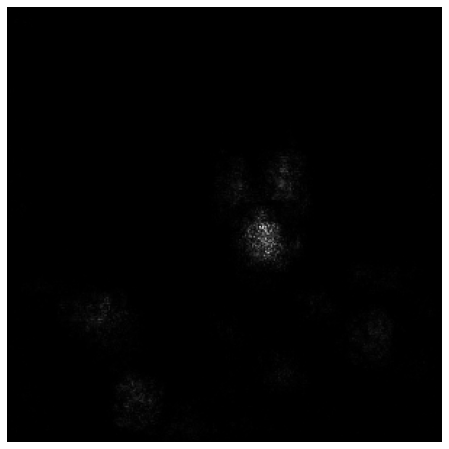

tf.Tensor([[8.6773434e-05 9.9991322e-01]], shape=(1, 2), dtype=float32)


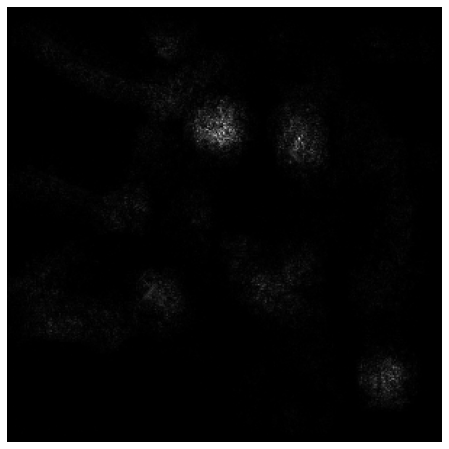

In [14]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY' -O 95_epochs.h5

model.load_weights('95_epochs.h5')

do_salience('cat1.jpg', model, 0, "epoch95_salient")
do_salience('cat2.jpg', model, 0, "epoch95_salient")
do_salience('catanddog.jpg', model, 0, "epoch95_salient")
do_salience('dog1.jpg', model, 1, "epoch95_salient")
do_salience('dog2.jpg', model, 1, "epoch95_salient")

**Congratulations on completing this week's assignment! Please go back to the Coursera classroom and upload the zipped folder to be graded.**